<a href="https://colab.research.google.com/github/Pathway2008/article_summary/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rouge_score
!pip install datasets
!pip install pytorch_lightning
!pip install transformers
!pip install konlpy

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=6cb39027ca15a89fcedbe20eb3e36ca067e2d9939cc159344793fca32da4fca2
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that a

In [ ]:
import torch
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

# 저장된 모델 & 토크나이저 로드
load_path = "/content/drive/MyDrive/article_summary/final_model"
tokenizer = PreTrainedTokenizerFast.from_pretrained(load_path)
model = BartForConditionalGeneration.from_pretrained(load_path).to("cuda" if torch.cuda.is_available() else "cpu")

# 기사 요약 함수
def summarize_article(article, model, tokenizer, max_length=128):
    inputs = tokenizer(article, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(model.device)

    with torch.no_grad():
        summary_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=max_length,
            num_beams=5,  # 빔서치 적용 (더 나은 요약 생성)
            length_penalty=1.0,  # 길이 조정
            early_stopping=True
        )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Okt
import matplotlib.font_manager as fm

article = pd.read_csv('/content/drive/MyDrive/article_summary/article01310205.csv')
article['date'] = pd.to_datetime(article['date'], format="mixed")
article = article.dropna(subset=['article'])
article = article[article['date'] >= '2025-01-23'].reset_index(drop=True)

In [ ]:
# article =pd.read_csv('/content/drive/MyDrive/article_summary/summary_0205.csv')

In [ ]:
article["summary_pred"] = article["article"].apply(lambda x: summarize_article(x, model, tokenizer))

KeyboardInterrupt: 

In [ ]:
article_0124 = article[article['date'] == '2025-01-24'].reset_index(drop=True)

# word cloud

Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


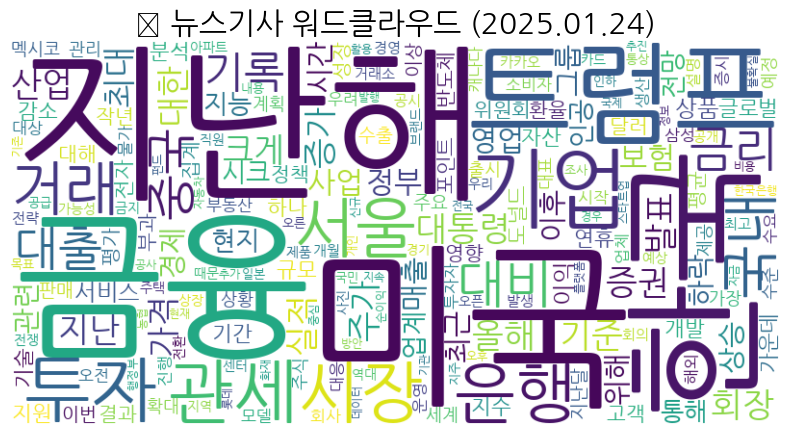

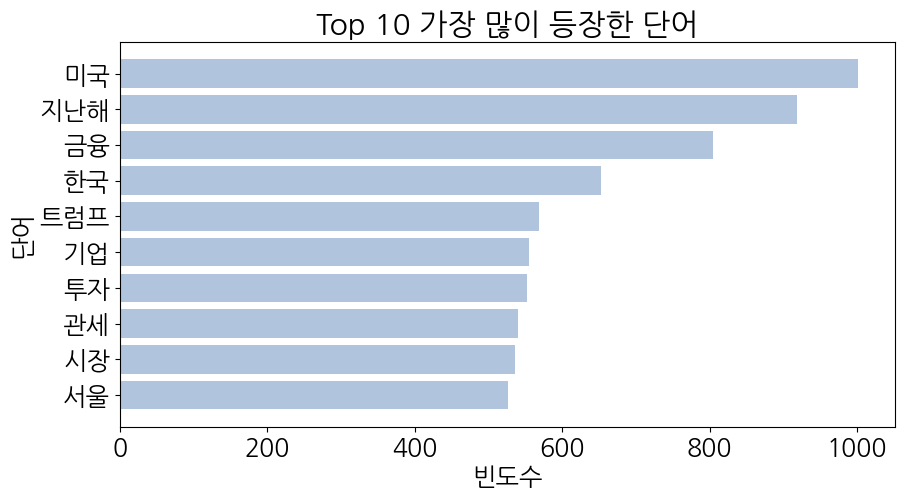

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Okt  # 한국어 형태소 분석기
import matplotlib.font_manager as fm

# Colab 환경에 한글 폰트 설치 (한 번만 실행)
!apt-get -qq install fonts-nanum
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # Linux/Colab 폰트 경로 설정

# Matplotlib에 한글 폰트 적용
fe = fm.FontEntry(fname=font_path, name="NanumGothic")
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({"font.size": 18, "font.family": "NanumGothic"})  # 폰트 설정

#'article' 컬럼 병합
text_data = " ".join(article["summary_pred"].dropna())

# 형태소 분석 및 명사 추출
okt = Okt()
words = okt.nouns(text_data)  # 명사만 추출

# 불용어 제거
stopwords = {"기자", "이", "것", "있다", "하다", "등", "및", "그", "수"}#'지난해','기업','투자','대비','시장','트럼프','미국'
words = [word for word in words if word not in stopwords and len(word) > 1]

# 단어 빈도수 계산
word_counts = Counter(words)
top10_words = word_counts.most_common(10)

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,  # 🚀 Linux/Colab 환경 폰트 경로 사용
    width=800,
    height=400,
    background_color="white"
).generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("📰 뉴스기사 워드클라우드 (2025.01.24)")
plt.show()

# Top 10 단어 시각화
top_words, top_counts = zip(*top10_words)
plt.figure(figsize=(10, 5))
plt.barh(top_words[::-1], top_counts[::-1], color="lightsteelblue")
plt.xlabel("빈도수")
plt.ylabel("단어")
plt.title("Top 10 가장 많이 등장한 단어")
plt.show()

In [ ]:
article.dropna(subset=['article_name'], inplace=True)
article.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2941 entries, 0 to 2941
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   article_name  2941 non-null   object        
 1   journalist    2220 non-null   object        
 2   publisher     2941 non-null   object        
 3   date          2941 non-null   datetime64[ns]
 4   article       2941 non-null   object        
 5   summary_pred  2941 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 160.8+ KB


In [ ]:
from konlpy.tag import Okt
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

okt = Okt()
stopwords = {"기자", "이", "것", "있다", "하다", "등", "및", "그", "수",'부총리','장관'}

# 명사 + 동사 + 형용사
def extract_keywords(text):
    if not isinstance(text, str):  # 예외 처리
        return []

    pos_tags = okt.pos(text, stem=True)  # 어간 추출(stemming)
    keywords = [word for word, tag in pos_tags if tag in ["Noun", "Verb", "Adjective"] and word not in stopwords and len(word) > 1]
    return keywords

# 제목, 기사 , 요약에서 키워드 추출
article["keywords"] = article.apply(lambda row: " ".join(extract_keywords(row['article'] + " " + row['article_name'] + " " + row['summary_pred'])), axis=1)

# TF-IDF 벡터라이저 적용
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(article["keywords"])

# TF-IDF 점수 계산
def count_tfidf_keywords(text, vectorizer):
    if not text.strip():  # 빈 문자열 처리
        return 0
    tfidf_values = vectorizer.transform([text]).toarray()[0]
    return np.sum(tfidf_values)

# 각 점수 계산
article["summary_score"] = article["summary_pred"].apply(lambda x: count_tfidf_keywords(x, vectorizer))
article["name_score"] = article["article_name"].apply(lambda x: count_tfidf_keywords(x, vectorizer))
article["article_score_raw"] = article["keywords"].apply(lambda x: count_tfidf_keywords(x, vectorizer))

# 기사 길이 정규화 (길이 보정)
article["article_length"] = article["article"].str.len().replace(0, 1)  # 0으로 나누는 오류 방지
article["article_score"] = article["article_score_raw"] / np.log1p(article["article_length"])  # 로그 변환 정규화

# 가중치 적용 (필요시 조정 가능)
name_weight = 0.6
article_weight = 1.0
summary_weight = 0.8

article["total_score"] = (
    name_weight * article["name_score"] +
    article_weight * article["article_score"] +
    summary_weight * article["summary_score"]
)

# 상위 5개 기사 추출
top_articles = article.sort_values(by="total_score", ascending=False).head(5)

# 결과 출력
display(top_articles[["summary_pred", "total_score"]])
display(top_articles["summary_pred"].iloc[0])  # 가장 높은 점수를 받은 기사 요약 출력

,summary_pred,total_score
664,국내 주요 배터리 제조사들이 업황 ‘보릿고개’에 대응해 투자 속도 조절에 들어간다....,5.975707
882,도널드 트럼프 미국 취임 이후 사상 최고치를 오가던 뉴욕증시가 닷새 만에 소폭 하락...,5.929668
1632,한국경영자총협회는 글로벌리서치에 의뢰해 지난달 6~17일 국내 대학 경제학과 교수 ...,5.696935
1874,설 연휴 이후 일주일 만에 열린 지난달 31일 외환시장에서 달러 대비 원화 환율은 ...,5.689503
2069,지난달 31일 오후 서울 중구 하나은행 본점 딜링룸 전광판에 증시 종가가 표시되고 ...,5.652866


'국내 주요 배터리 제조사들이 업황 ‘보릿고개’에 대응해 투자 속도 조절에 들어간다. 이창실 엘지(LG)에너지솔루션 최고재무책임자(CFO)는 24일 실적 설명회에서 “당분간 투자를 최소화하고 기존 생산 능력(capacity)의 운용 효율화에 집중할 것”이라며 “최근 2년간 설비투자(capex)를 확대해 왔으나, 올해는 전년 대비 3조원 줄여 관리할 예정”이라고 말했다. 전기차 수요 둔화, 미국 트럼프 2기 행정부의 정책 불확실성 확대 등에 따라 신규 투자 규모를 줄이고 재무 건전성에 초점을 맞추겠다는 얘기다.'

In [ ]:
display(top_articles['summary_pred'].iloc[0],'\n')
display(top_articles['summary_pred'].iloc[1],'\n')
display(top_articles['summary_pred'].iloc[2],'\n')
display(top_articles['summary_pred'].iloc[3],'\n')
display(top_articles['summary_pred'].iloc[4])

'국내 주요 배터리 제조사들이 업황 ‘보릿고개’에 대응해 투자 속도 조절에 들어간다. 이창실 엘지(LG)에너지솔루션 최고재무책임자(CFO)는 24일 실적 설명회에서 “당분간 투자를 최소화하고 기존 생산 능력(capacity)의 운용 효율화에 집중할 것”이라며 “최근 2년간 설비투자(capex)를 확대해 왔으나, 올해는 전년 대비 3조원 줄여 관리할 예정”이라고 말했다. 전기차 수요 둔화, 미국 트럼프 2기 행정부의 정책 불확실성 확대 등에 따라 신규 투자 규모를 줄이고 재무 건전성에 초점을 맞추겠다는 얘기다.'

'\n'

'도널드 트럼프 미국 취임 이후 사상 최고치를 오가던 뉴욕증시가 닷새 만에 소폭 하락을 기록했다. 1월 마지막 주 미 연방준비제도(Fed)의 기준금리 결정과 애플, 마이크로소프트, 메타 등 주요 기술 기업 실적이 한꺼번에 공개되는 등 시장의 불확실성이 확대됐다. 트럼프 정부가 암호화폐에 대한 정책 자문위원회를 구성하는 등 지원책에 속도를 내고 있지만, 비트코인 등 주요 자산들의 가격은 크게 오르지 못했다.'

'\n'

'한국경영자총협회는 글로벌리서치에 의뢰해 지난달 6~17일 국내 대학 경제학과 교수 100명을 대상으로 실시한 ‘최근 경제 상황과 주요 현안 조사’ 결과를 2일 발표했다. 조사에 따르면 경제학자들의 올해 한국 경제성장률 전망치는 평균 1.6%로, 정부 전망치(1.8%)보다 낮게 나타났다. 글로벌 경쟁력 제고와 저성장 극복을 위한 정책 필요성과 시급성을 평가(10점 척도)한 결과 ‘산업 구조개혁 촉진’과 ‘노동시장 선진화’, ‘기업 규제 개선’이 필요하다는 응답이 90%를 넘었다.'

'\n'

'설 연휴 이후 일주일 만에 열린 지난달 31일 외환시장에서 달러 대비 원화 환율은 큰 폭으로 상승해 다시 1450원대로 올라섰다. 이날 원·달러 환율(오후 3시 30분 기준)은 직전 거래일인 지난달 24일보다 21.40원 상승한 1452.70원에 거래를 마쳤다. 도널드 트럼프 미국 대통령이 2월 1일부터 멕시코와 캐나다에 25% 관세를 부과하기로 한 데다, 설 연휴 기간 발생한 중국 인공지능(AI) 스타트업 딥시크 충격, 미 연준의 매파적 금리 동결 등 대외 변수가 한꺼번에 반영된 결과로 풀이된다.'

'\n'

"지난달 31일 오후 서울 중구 하나은행 본점 딜링룸 전광판에 증시 종가가 표시되고 있다. /사진=뉴스13일 코스피지수가 장 초반 2% 이상 떨어지면서 2500선을 내줬다. 도널드 트럼프 미국 대통령이 캐나다·멕시코·중국에 관세를 전면 부과키로 하면서 국가 간 '관세 전쟁'이 격화할 것이란 우려가 반영된 것으로 풀이된다. 이에 원·달러 환율은 17원가량 오르며 1470원을 돌파했다."